Instalare biblioteca **SNNTORCH**

In [3]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.6 MB/s eta 0:00:00


In [4]:
import snntorch as snn
from snntorch import spikeplot as splt

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt

Dataset MNIST

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])

# descarcarea setului de date MNIST pentru antrenare cat si testare
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
#imagini impartite in batch-uri pentru o procesare eficienta pe GPU/CPU


Definirea modelul SNN(Spiking Neural Network)

In [30]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()

        self.flatten = nn.Flatten()
        #flattern- transformarea imaginei 28x28 in vector de 784

        self.fc1 = nn.Linear(28*28, 512)
        self.lif1 = snn.Leaky(beta=0.5)

        self.fc2 = nn.Linear(512, 10)
        self.lif2 = snn.Leaky(beta=0.5)

        #Leaky Integrate-and-Fire (LIF)
        #beta controleaza leak-ul


    def forward(self, x, time_steps=25):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk_out_rec = []

        x = self.flatten(x)

        for step in range(time_steps):
            #x = self.flatten(x)
            curent1 = self.fc1(x)
            spk1, mem1 = self.lif1(curent1, mem1)

            curent2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(curent2, mem2)

            spk_out_rec.append(spk2)

        return torch.stack(spk_out_rec, dim=0)


Initializare model SNN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SNN().to(device)

In [8]:
images, labels = next(iter(test_loader))
images = images.to(device)
spk_output = model(images, time_steps=25)
print("Output:", spk_output.shape)#[timesteps, batch_size, output_classes]

Output: torch.Size([25, 128, 10])


Functie Antrenare model

In [9]:
def train_snn(model, train_loader, optimizer, device, num_epochs=5, time_steps=25):
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        #parcurgerea batch-urilor din setul de antrenare
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            spk_out = model(images, time_steps=time_steps)
            out = spk_out.mean(dim=0)#media spike-urilor

            #calculul pierdere -CrossEntropyLoss
            loss = loss_fn(out, labels)
            #backpropagation
            loss.backward()
            optimizer.step()

            #statistici pentru evaluare: pierderea acumulata, nr predictii corecte, total imagini
            total_loss += loss.item()
            _, predicted = out.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        #afisare
        acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}%")


Initializare functia de antrenare

In [10]:
model = SNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_snn(model, train_loader, optimizer, device, num_epochs=5, time_steps=25)


Epoca [1/5] - Loss: 737.0401 - Acuratețe: 88.14%
Epoca [2/5] - Loss: 706.6613 - Acuratețe: 94.22%
Epoca [3/5] - Loss: 701.1112 - Acuratețe: 95.49%
Epoca [4/5] - Loss: 697.7565 - Acuratețe: 96.43%
Epoca [5/5] - Loss: 695.7095 - Acuratețe: 97.03%


Functie Testare



In [31]:
def evaluate_snn(model, test_loader, device, time_steps=25):
    model.eval()
    correct = 0
    total = 0

    #fara gradient-memorie si calcule economisite
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            #trecem imaginile prin reteaua spiking timp de "time_steps"
            spk_out = model(images, time_steps=time_steps)
            out = spk_out.mean(dim=0)

            #predictie si scor
            _, predicted = out.max(1)
            #comparam predictiile cu etichetele reale si numaram cate sunt corecte
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #afisare
    acc = 100. * correct / total
    print(f"Acuratetea pe setul de testare: {acc:.2f}%")

evaluate_snn(model, test_loader, device)


Acuratetea pe setul de testare: 96.66%


Matricea de confuzie normalizata

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import files

def evaluate_snn_confusion_matrix(model, test_loader, device, time_steps=25, save_fig=True, download_fig=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            spk_out = model(images, time_steps=time_steps)
            out = spk_out.mean(dim=0)

            _, predicted = out.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #matricea de confuzie
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #afisare
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Etichete prezise")
    plt.ylabel("Etichete reale")
    plt.title("Matricea de confuzie normalizata - SNN pe MNIST")

    #salvare imagine
    if save_fig:
        plt.savefig("matrice_confuzie_snn.png")
    plt.show()

    #descarcare imagine
    if download_fig:
        files.download("matrice_confuzie_snn.png")

    #acuratete
    acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Accuracy: {acc:.2f}%")


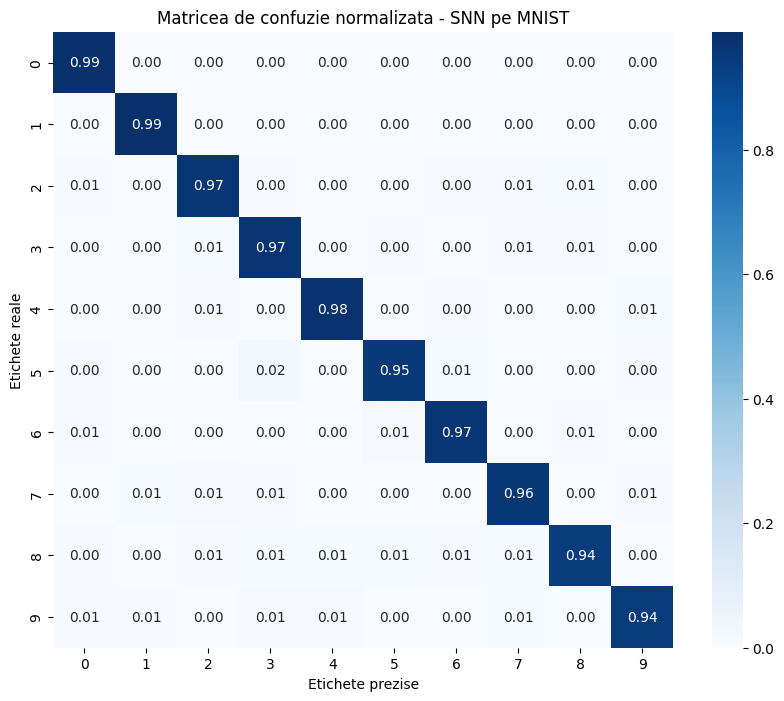

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy: 96.66%


In [41]:
evaluate_snn_confusion_matrix(model, test_loader, device, time_steps=25, save_fig=True, download_fig=True)
